#### Import Libraries for Passenger

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('D:/Subhradeep/Dataset/DC/Timeseries/AirPassengers.csv',parse_dates=['Month'],index_col='Month')
df.rename(columns={'#Passengers':'Passengers'},inplace=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Observation: 
    
    There are only two columns present, Month and Passengers. We will use the column Passengers to be forecasted.
    

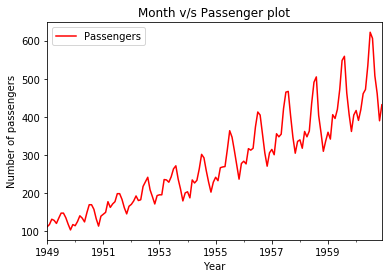

In [4]:
df.plot(color='red')
plt.title('Month v/s Passenger plot')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.show()

From the above plot it is clear there is a <b>Trend</b> component. So let's check for the stationarity.

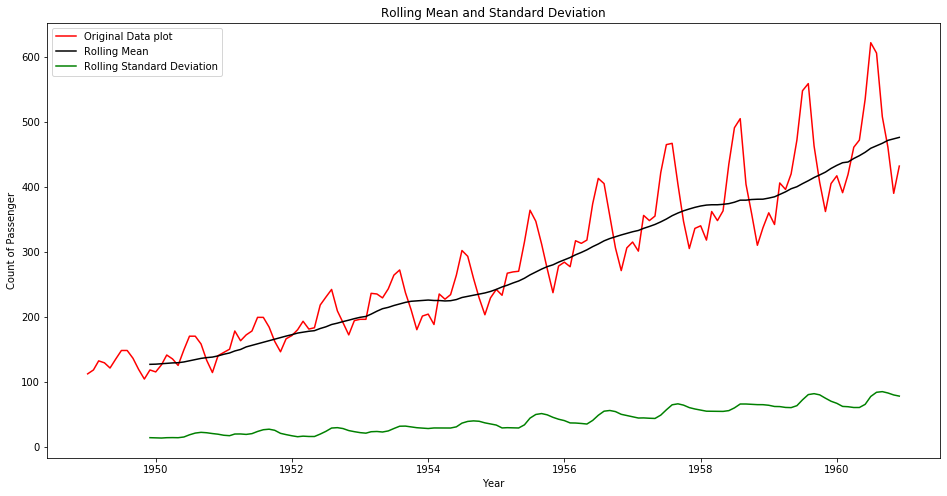

In [5]:
#Rolling statistics

def roll_mean_std(ts):
    
    rolling_mean = ts.rolling(window=12).mean() #12 month window
    rolling_std = ts.rolling(window=12).std()
    rolling_mean.dropna(inplace=True)
    rolling_std.dropna(inplace=True)
    plt.figure(figsize=(16,8))
    orig = plt.plot(ts,color='red',label ='Original Data plot')
    rmean = plt.plot(rolling_mean,color='black',label='Rolling Mean')
    rstd = plt.plot(rolling_std,color='green',label='Rolling Standard Deviation')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Year')
    plt.ylabel('Count of Passenger')
    plt.legend(loc='upper left')
    plt.show()
    
roll_mean_std(df)

#### Observation: 
    
    a. From the above plot it is clear that rolling mean(black) has Trend.
    b. Rolling Standard Deviation(green line) is mostly constant with time.


Since the curve is not stationary, let's try to have Dickey Fuller test. 

In [6]:
from statsmodels.tsa.stattools import adfuller

#Function to check for ADFULLER Test summary

def adfuller_test(ts):    
    adf = adfuller(ts,autolag='AIC')
    print('\nResult Summary for Dickey Fuller Test is as below: \n')
    #print(adf)
    print('Test Statistics is :',adf[0])
    print('P Value is:',adf[1])
    print('Lags used',adf[2])
    print('Number of Observation',adf[3])
    print('Critical Values are as follows :',adf[4])
    
adfuller_test(df['Passengers'])
    
    


Result Summary for Dickey Fuller Test is as below: 

Test Statistics is : 0.8153688792060433
P Value is: 0.9918802434376409
Lags used 13
Number of Observation 130
Critical Values are as follows : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


#### Observation of Dickey fuller test :
    
    a. From the above on the original dataframe Dickey fuller test, P-Value is 0.99 which is large(max it can be 1).
    b. Critical values should be closed to the Test Statistics, but it is no where close.
    
So from the dickey fuller test it is clear , our time series is not <b>Stationary</b>

#### Converting to Stationary data:
    
There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ....

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

<b>Log Scale Transformation : </b>
    
        We will use the numpy method of log to transform and then will apply the transformed data to rolling mean function.

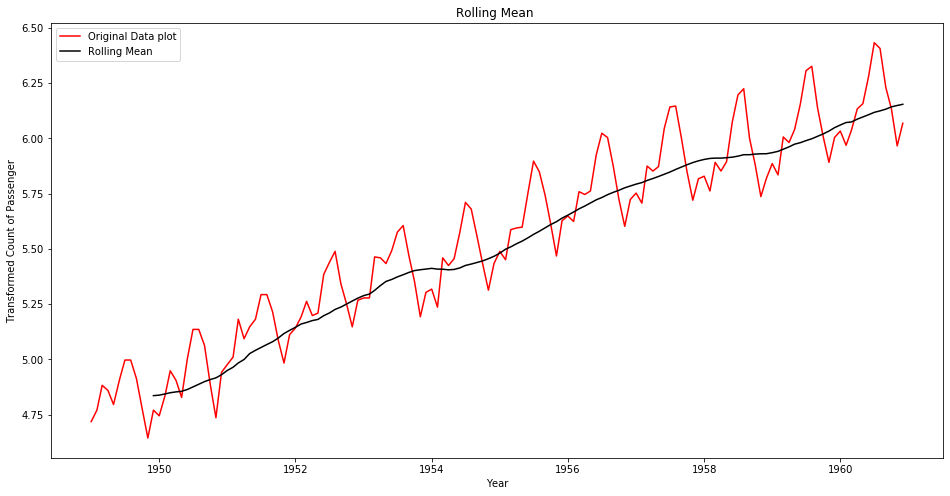

In [7]:
df_log_transformation = np.log(df) 

#Applying rolling statistics for the log transformed data.

def roll_mean(ts):
    
    rolling_mean = ts.rolling(window=12).mean() #12 month window
    #rolling_std = ts.rolling(window=12).std()
    rolling_mean.dropna(inplace=True)
    #rolling_std.dropna(inplace=True)
    plt.figure(figsize=(16,8))
    orig = plt.plot(ts,color='red',label ='Original Data plot')
    rmean = plt.plot(rolling_mean,color='black',label='Rolling Mean')
    #rstd = plt.plot(rolling_std,color='green',label='Rolling Stadard Deviation')
    plt.title('Rolling Mean ')
    plt.xlabel('Year')
    plt.ylabel('Transformed Count of Passenger')
    plt.legend(loc='upper left')
    plt.show()
    
roll_mean(df_log_transformation)


From the above plot, it is clear that the timeseries is still not stationary but it is better than the previous. 

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

logscaleL=stationarypart(L1)+trend(LT)

movingavgoflogscaleA=stationarypart(A1)+trend(AT) 

resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT) 

Since, L & A are series & it moving avg, their trend will be more or less same, Hence LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have, R=L1−A1 , our final non-trend curve

In [8]:
df_log_scale_minus_mavg = df_log_transformation - (df_log_transformation.rolling(window=12).mean())
df_log_scale_minus_mavg.dropna(inplace=True)
pd.DataFrame(df_log_scale_minus_mavg.head())

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


<b>Plotting the Transformed Data</b>

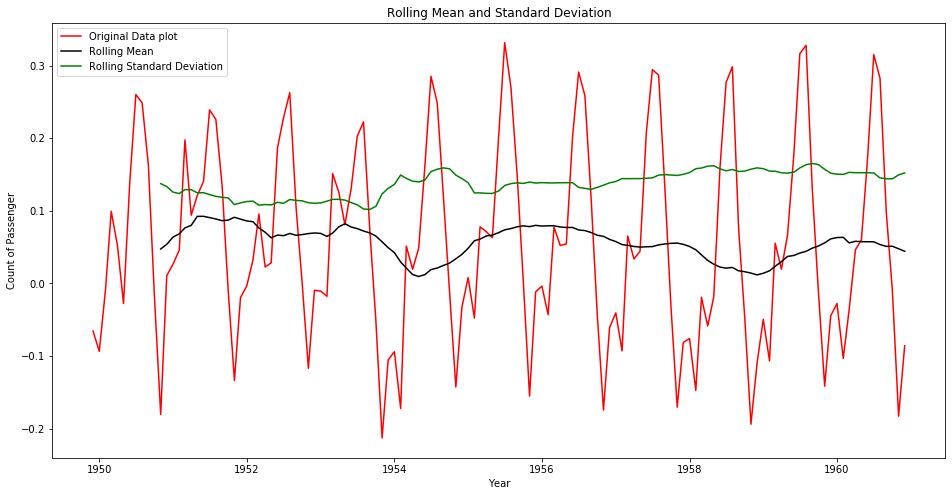

In [9]:
roll_mean_std(df_log_scale_minus_mavg)

#### <b>Running the Dickey Fuller Test on Transformed Data.....</b>

In [10]:
adfuller_test(df_log_scale_minus_mavg['Passengers'])


Result Summary for Dickey Fuller Test is as below: 

Test Statistics is : -3.162907991300849
P Value is: 0.022234630001244364
Lags used 13
Number of Observation 119
Critical Values are as follows : {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}


<b>From the above two plots :</b>
    
    a. Critical Values are close to Test Statistics which is good and the data is almost stationary.
    b. P value is decreased from 0.99 to 0.22
    
    
<b>Exponential Weighted Function:</b>

           We will plot ewf to check the curve. We will use pandas.DataFrame.ewm
           
  <b>Parameters:</b>
           
           halflifefloat:- Specify decay in terms of half-life, α=1−exp(log(0.5)/halflife),forhalflife>0.
           min_periods:- Minimum number of observations in window required to have a value (otherwise result is NA).
           Adjust:- Divide by decaying adjustment factor in beginning periods to account for imbalance in relative weighting                    (viewing EWMA as a moving average).

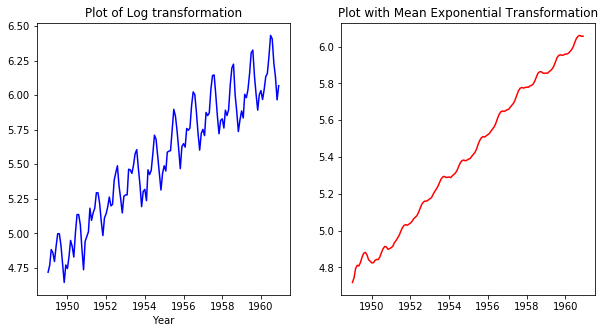

In [11]:
df_log_transformation_ewm = df_log_transformation.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(df_log_transformation,color='blue')
plt.title('Plot of Log transformation')
plt.xlabel('Year')


plt.subplot(122)
plt.plot(df_log_transformation_ewm,color='red')
plt.title('Plot with Mean Exponential Transformation')
plt.show()

From the above plot it is clear that there is a minimum advantage with decay transformation. However we will try to run dickey fuller test so we can understand a better picture.


In [12]:
df_log_ewm_minus_mvg = df_log_transformation-df_log_transformation_ewm

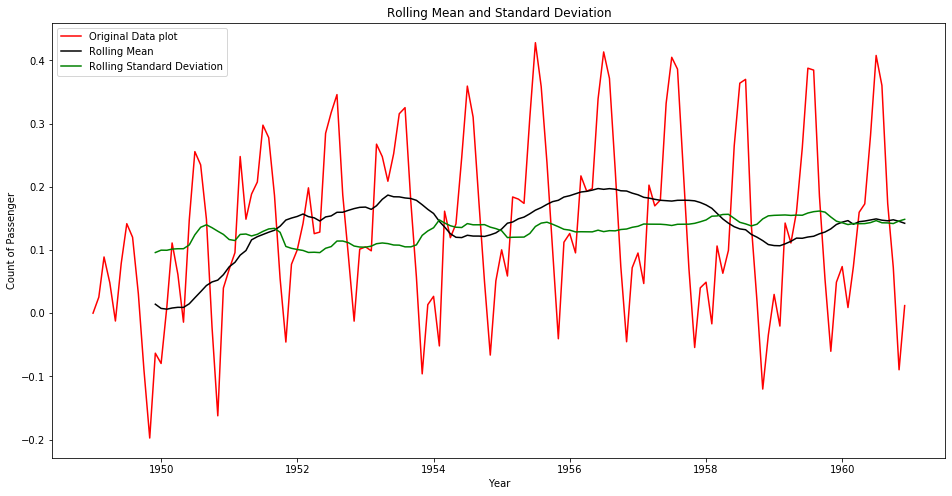


Result Summary for Dickey Fuller Test is as below: 

Test Statistics is : -3.601262420161657
P Value is: 0.0057369388015122555
Lags used 13
Number of Observation 130
Critical Values are as follows : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [13]:
roll_mean_std(df_log_ewm_minus_mvg['Passengers'])
adfuller_test(df_log_ewm_minus_mvg['Passengers'])

<b>Observation of Exponential Weighted Function v/s Log Transformation:</b>
    
            a. Critical Values are more closer to Test Statistics.
            b. P Value is now more less(0.005) than log transformation value(0.22)

#### Shift() Transformation:
    
    We will apply same method however we will now use the .shift().
    Moves data between past and future. Defaults 1 period into the future.

    -1 shifts data from past to present.

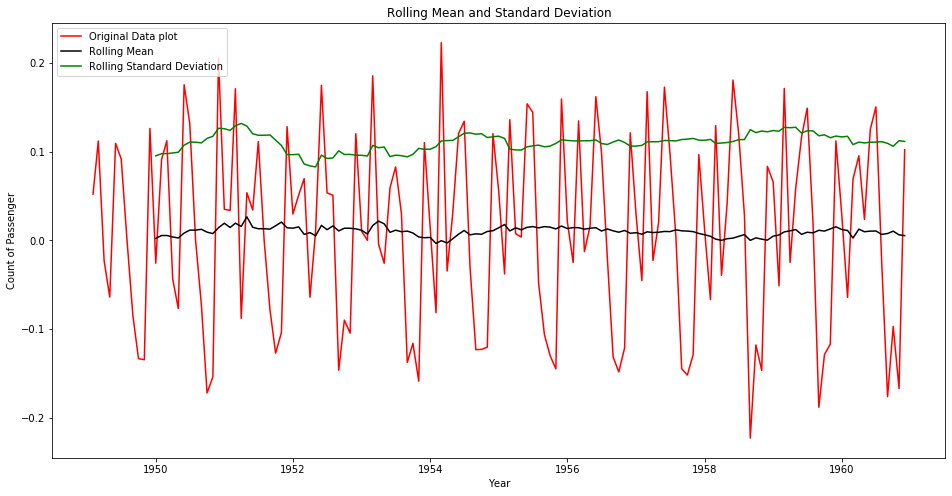


Result Summary for Dickey Fuller Test is as below: 

Test Statistics is : -2.717130598388118
P Value is: 0.07112054815086118
Lags used 14
Number of Observation 128
Critical Values are as follows : {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}


In [14]:
df_log_transformation_shift = df_log_transformation-df_log_transformation.shift()
df_log_transformation_shift.dropna(inplace=True)
roll_mean_std(df_log_transformation_shift)
adfuller_test(df_log_transformation_shift['Passengers'])

#### Observation of Shift Transformation with rest of the Transformation applied:

            a. P Value is significantly larger than any other transformation.
            b. Critical values are not near to the Test statistics.
            
            
We will use log transformation for rest of the notebook. Plotting the seasonality,trend and residuals

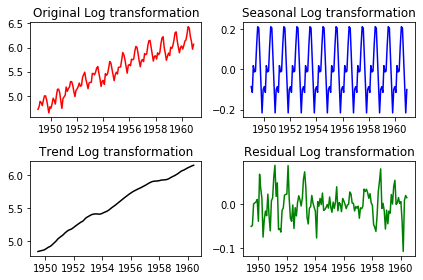

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose #library for seasonal_decompose

decomposition = seasonal_decompose(df_log_transformation)

fig, axs = plt.subplots(2, 2)
axs[0,0].plot(df_log_transformation,color='red')
axs[0,0].set_title('Original Log transformation')
plt.tight_layout()

axs[0,1].plot(decomposition.seasonal,color='blue')
axs[0,1].set_title('Seasonal Log transformation')

axs[1,0].plot(decomposition.trend,color='black')
axs[1,0].set_title('Trend Log transformation')
plt.tight_layout()

axs[1,1].plot(decomposition.resid,color='green')
axs[1,1].set_title('Residual Log transformation')
plt.tight_layout()


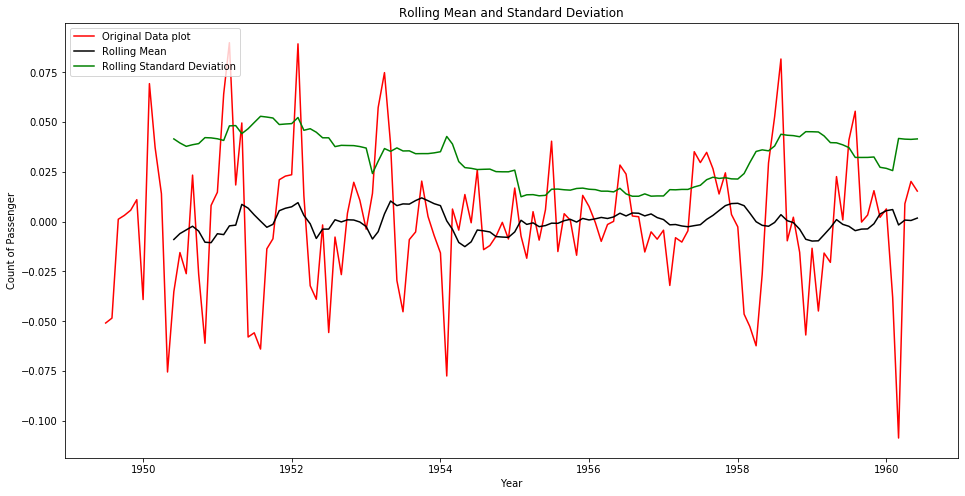


Result Summary for Dickey Fuller Test is as below: 

Test Statistics is : -6.33238679764488
P Value is: 2.8850589033231607e-08
Lags used 9
Number of Observation 122
Critical Values are as follows : {'1%': -3.4851223522012855, '5%': -2.88553750045158, '10%': -2.5795685622144586}


In [16]:
decompose_trans_log = decomposition.resid
decompose_trans_log.dropna(inplace=True)
roll_mean_std(decompose_trans_log)
adfuller_test(decompose_trans_log)

#### Plotting ACF & PACF:

C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


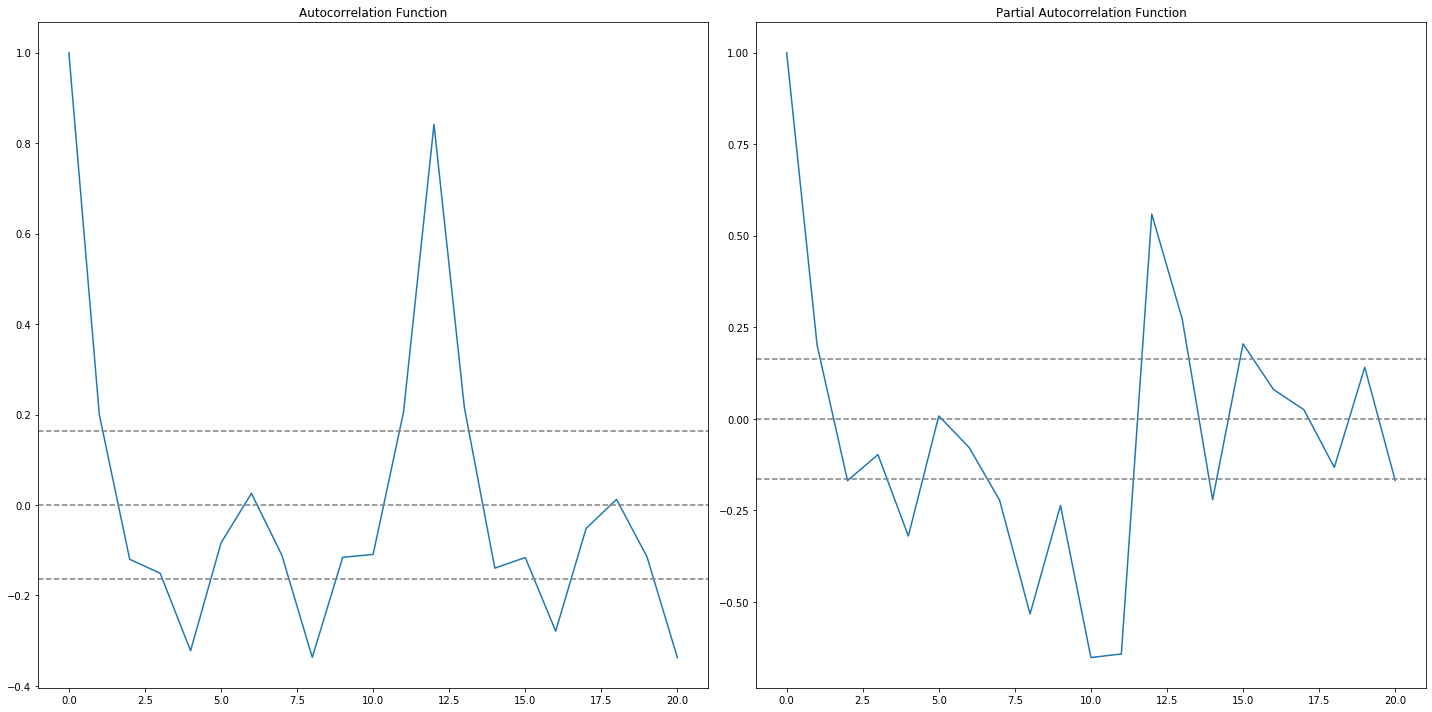

In [17]:
from statsmodels.tsa.stattools import acf,pacf
plt.figure(figsize=(20,10))
acf_lag = acf(df_log_transformation_shift,nlags=20)
pacf_lag = pacf(df_log_transformation_shift,nlags=20)

#ACF
plt.subplot(121) 
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_transformation_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_transformation_shift)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

 #PACF
plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_transformation_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_transformation_shift)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

From the ACF graph, we see that curve touches y=0.0 line at x=2. So Q = 2.From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, So, P = 2

### Model Building

C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


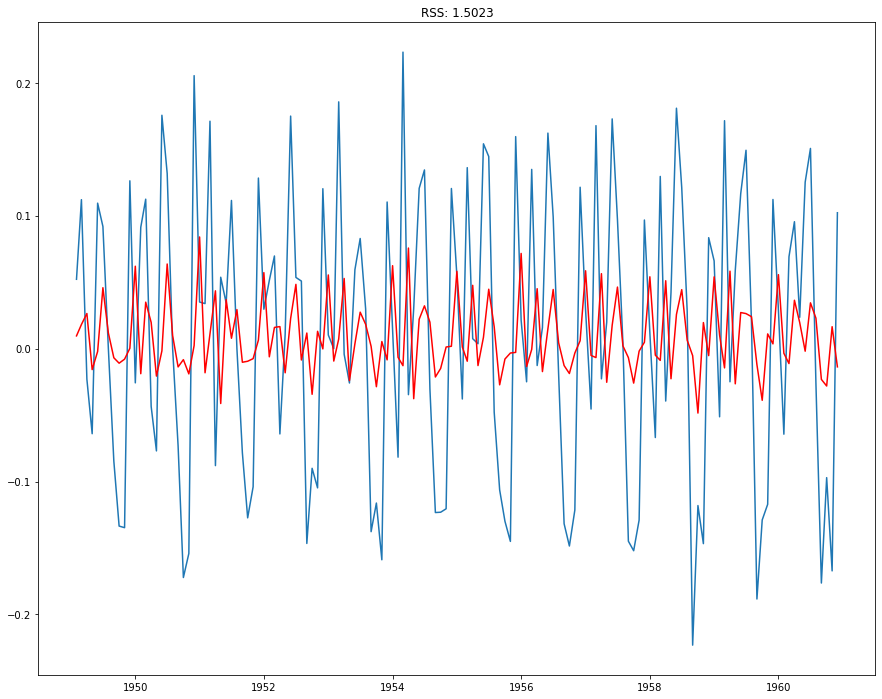

In [25]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_log_transformation, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,12))
plt.plot(df_log_transformation_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_log_transformation_shift['Passengers'])**2))
print('Plotting AR model')





MA Model

Plotting MA model


C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


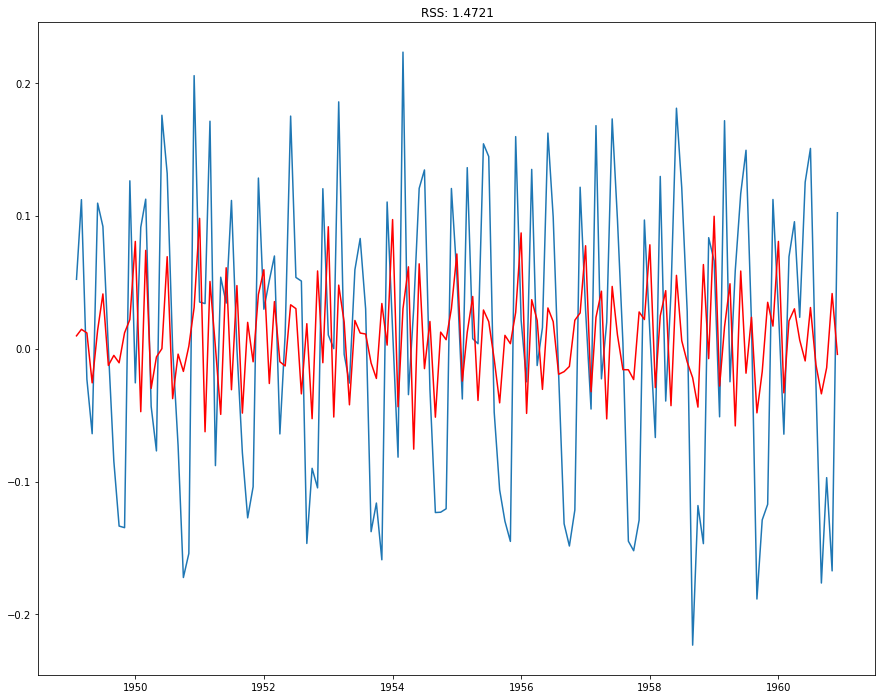

In [27]:
model = ARIMA(df_log_transformation, order=(0,1,2))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,12))
plt.plot(df_log_transformation_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_log_transformation_shift['Passengers'])**2))
print('Plotting MA model')



### AR+I+MA model

C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\subhr\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting AR model


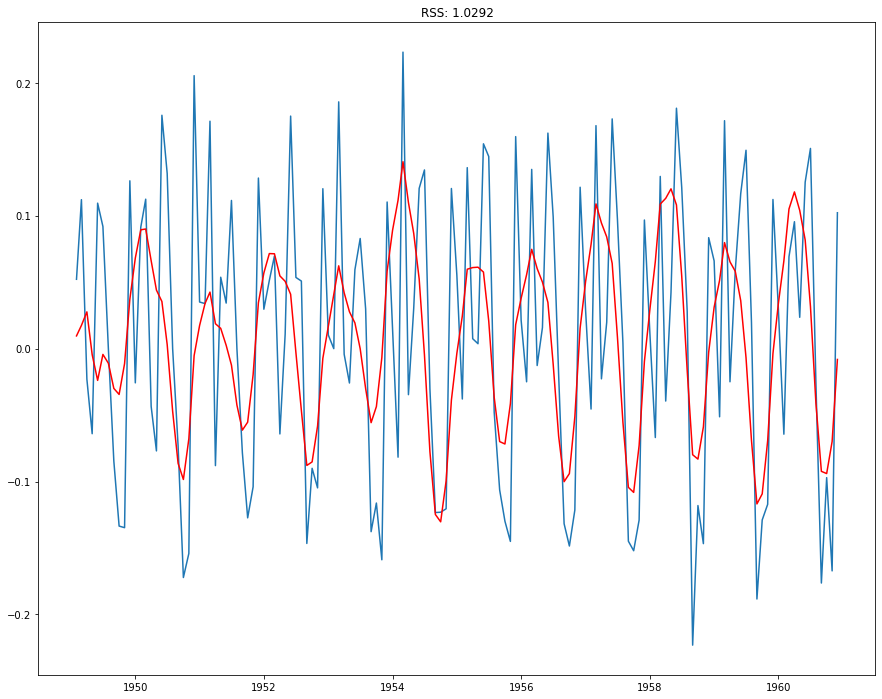

In [28]:
model = ARIMA(df_log_transformation, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.figure(figsize=(15,12))
plt.plot(df_log_transformation_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df_log_transformation_shift['Passengers'])**2))
print('Plotting AR model')


By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

### Reverse Transformation and Predictions

In [35]:
arima_prediction_diff = pd.Series(results_AR.fittedvalues,copy=True)
arima_prediction_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [36]:
#Cumulative Sum

arima_prediction_cum = arima_prediction_diff.cumsum()
arima_prediction_cum.head()


Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [41]:
arima_prediction_log = pd.Series(df_log_transformation['Passengers'].iloc[0],index=df_log_transformation.index)
arima_prediction_log = arima_prediction_log.add(arima_prediction_cum,fill_value=0)
arima_prediction_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

### Exponential Transformation

In [45]:
prediction_arima = np.exp(arima_prediction_log) #opposite of log transformation
prediction_arima.head()


Month
1949-01-01    112.000000
1949-02-01    113.078122
1949-03-01    115.073414
1949-04-01    118.301985
1949-05-01    117.768361
dtype: float64

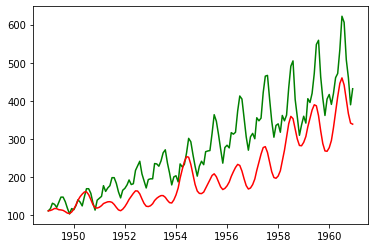

In [46]:
plt.plot(df,color ='green')
plt.plot(prediction_arima,color='red')
plt.show()

### Plotting future/forecast 10 years

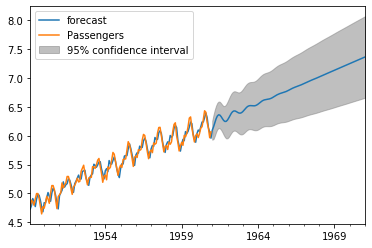

In [53]:
results_AR.plot_predict(1,264)
plt.show()

In [90]:
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Tue, 21 Jul 2020   AIC                           -287.281
Time:                        14:31:00   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.Passengers    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.Passengers    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.Passengers     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

In [92]:
results_AR.forecast(steps=120)

(array([6.09553398, 6.1528141 , 6.22442968, 6.29241096, 6.34164702,
        6.36359342, 6.35784664, 6.33139285, 6.29597526, 6.26447706,
        6.24738323, 6.25025171, 6.27275834, 6.30940305, 6.3515148 ,
        6.38988636, 6.41727358, 6.43011029, 6.42906667, 6.41842471,
        6.40456142, 6.39403606, 6.39183075, 6.40019495, 6.41833681,
        6.44295391, 6.46937414, 6.49293961, 6.51024093, 6.51989008,
        6.52267555, 6.52112367, 6.5186451 , 6.51853675, 6.52311908,
        6.53322344, 6.54812851, 6.56591535, 6.58410283, 6.60036512,
        6.61313238, 6.62192753, 6.62737763, 6.63093105, 6.63438667,
        6.63937964, 6.64696483, 6.65739818, 6.670153  , 6.68414224,
        6.69806597, 6.71077871, 6.72157701, 6.73033953, 6.73749781,
        6.7438635 , 6.75037296, 6.75782566, 6.76668655, 6.77699795,
        6.78841289, 6.80032822, 6.81207162, 6.82308726, 6.83307102,
        6.84202459, 6.85022279, 6.85811188, 6.86617308, 6.87479119,
        6.8841627 , 6.8942635 , 6.90487855, 6.91